In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import plot as plt
import seaborn as sbs

In [2]:
pd.set_option('display.max_columns', 15)                                                    #кол-во выводимых колонок в консоле
pd.set_option('display.width', 300)                                                         #ширина окна с выводом
sbs.set(rc={'figure.figsize':(9,6)})                                                        #размер гистограммы


In [3]:
events_data = pd.read_csv('C:/Users/AndreyPC/PycharmProjects/Data_Science/Project/event_data_train.csv')


In [4]:
submission_data = pd.read_csv('C:/Users/AndreyPC/PycharmProjects/Data_Science/Project/submissions_data_train.csv')

In [5]:
events_data.action.unique()                                                                #список уникальных значений в столбце
                                                                                           #action

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
events_data = events_data.assign(date = pd.to_datetime(events_data.timestamp, unit = 's'))  #перевод Unix формата времени 
                                                                                            #в обычный c добавлением колонки date

In [7]:
events_data = events_data.assign(day = events_data.date.dt.date)                            #добавление колонки day 

In [8]:
events_data.dtypes


step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

In [9]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [10]:
events_data.date.max()


Timestamp('2018-05-19 23:33:31')

In [11]:
events_data.groupby('day', as_index = False).agg({'user_id':'nunique'}).head(20)            #количество уникальных пользователей по дням

,day,user_id
0,2015-06-15,705
1,2015-06-16,526
2,2015-06-17,440
3,2015-06-18,411
4,2015-06-19,377
5,2015-06-20,294
6,2015-06-21,292
7,2015-06-22,516
8,2015-06-23,520
9,2015-06-24,471


<AxesSubplot:>

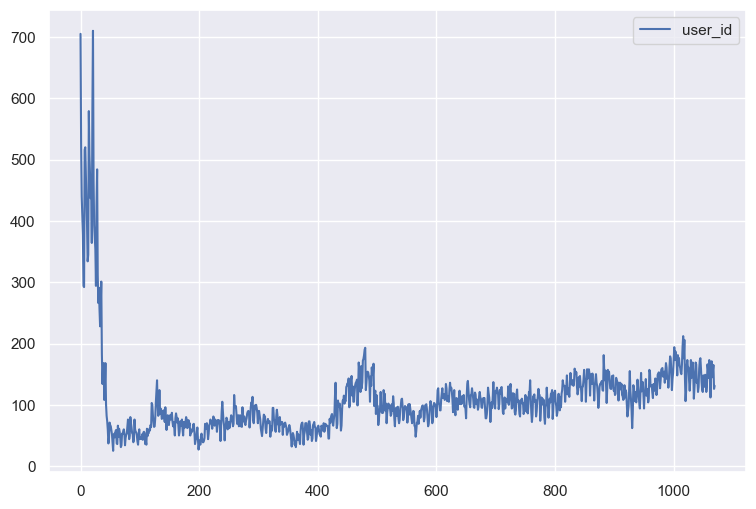

In [12]:
events_data.groupby('day', as_index = False).agg({'user_id':'nunique'}).plot()              #график числа уникальных пользователей по дням

<AxesSubplot:>

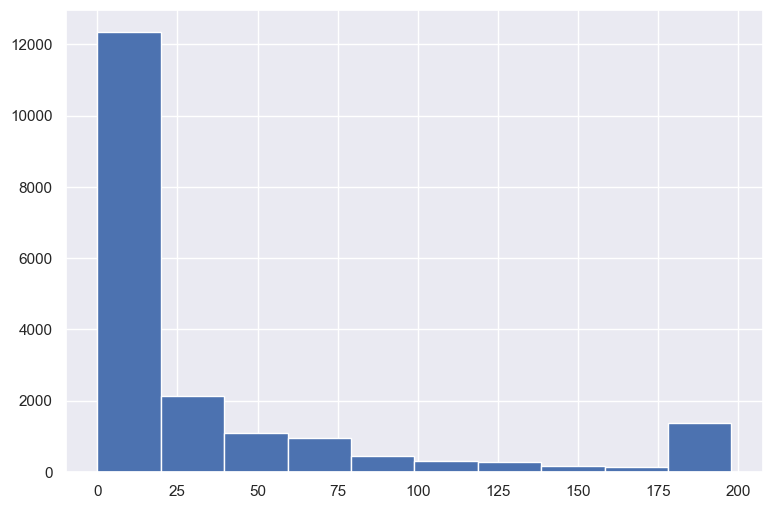

In [13]:
events_data.pivot_table(index='user_id',                                                    #диаграмма распределения
                        columns='action',                                                   #числа пользователей по кол-ву пройденных ими степов
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).passed.hist()

In [14]:
submission_data = submission_data.assign(date = pd.to_datetime(submission_data.timestamp, unit='s'))

In [15]:
submission_data = submission_data.assign(day = submission_data.date.dt.date)

In [16]:
users_scores = submission_data.pivot_table(index='user_id', 
                                           columns='submission_status',                      #число правильных и неправильных ответов
                                           values='step_id',                                 #у каждого ученика
                                           aggfunc='count', 
                                           fill_value=0).reset_index()

In [17]:
users_scores.user_id.nunique()                                                               #проверка числа учеников

9940

In [18]:
submission_data.user_id.nunique()                                                            #должно совпадать

9940

In [19]:
events_data_passed = events_data.pivot_table(index='user_id', 
                                             columns='action',                              #число различных действий 
                                             values='step_id',                              #каждого ученика
                                             aggfunc='count', 
                                             fill_value=0).reset_index()

In [20]:
events_data_passed.user_id.nunique()

19234

In [21]:
events_data.user_id.nunique()

19234

In [22]:
gap_data = events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values                                                                                      #удаляем повторные заходы пользователя на курс в течение дня
                                                                                                                #группируем по user_id b и делаем списки со временем заходов на курс для каждого пользователя
                                                                                                                #делаем списки с разницей между двумя соседними значениями (перерывы между заходами на курс)
                                                                                                                #с помощью values сохраняем в массив полученные списки

In [23]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))                   #объединяем в один массив данные из первых подмассивов gap_data и создаем серию

In [24]:
gap_data = gap_data/(24*60*60)                                             #перевод в дни

<AxesSubplot:>

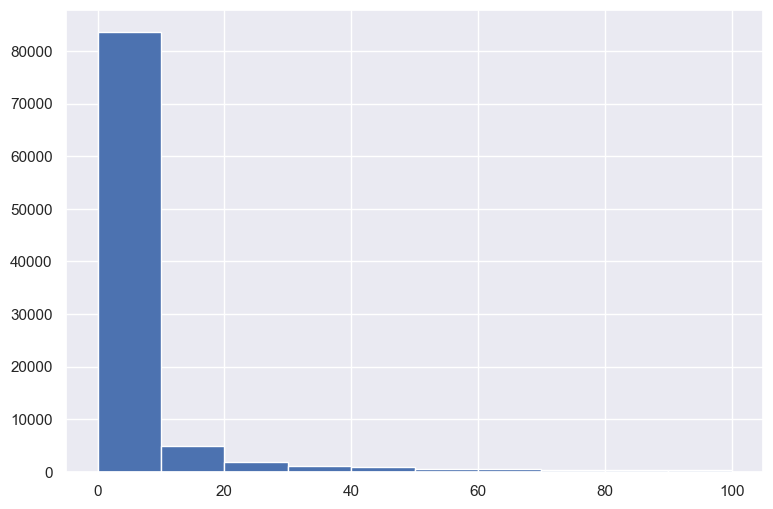

In [25]:
gap_data[gap_data < 100].hist()                                            #гистограмма перерывов между заходами на курс среди пользователей (лимит до 100 дней)

In [26]:
drop_out_time = gap_data.quantile(0.90)                                    #время перерыва между заходами на урок, которое не превышают 90% пользователей


In [27]:
now = events_data.timestamp.max()                                          #последнее время наблюдений 

In [28]:
user_data = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})  #находим время последнего посещения курса пользователями                             

In [29]:
user_data['is_gone'] = (now - user_data.last_timestamp) > 30*24*60*60        #сравниваем разницу между текущим временем и временем последнего посещения 
                                                                             #пользователем курсов со найденным перерывом между посещениями -
                                                                             #приблизительная разница между 95-ым перцентилем в 60 и 90-м перцентилем в 18 дней

In [30]:
user_data = user_data.merge(users_scores, on='user_id', how='outer')           #объединяем с таблицей users_score по User_id, отсутствующие значения будут как NaN

In [31]:
user_data = user_data.fillna(0)                                                #заменяем NaN на 0

In [32]:
user_data = user_data.merge(events_data_passed, on = 'user_id', how='outer')   #добавляем таблицу events_data_passed

In [33]:
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()   #число дней на курсе каждого пользователя

In [34]:
user_data = user_data.merge(user_days, on = 'user_id', how='outer')            #добавляем таблицу user_days

In [35]:
user_data.user_id.nunique()                                                    #проверяем кол-во user_id (должно совпадать с первоначлаьной таблицей)

19234

In [36]:
events_data.user_id.nunique()

19234

In [37]:
user_data['passed_course'] = user_data.passed > 170                            #cоздаем новую колонку, где будем сранивать кол-во пройденных уроков с заданным (условно) значением

In [38]:
user_data.groupby('passed_course').count().reset_index()                       #соотношение числа прошедших и покинувших курс

,passed_course,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
1,True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [39]:
"""Можно ли по поведению пользователя за первые 3 дня предсказать, закончит ли он курс """

'Можно ли по поведению пользователя за первые 3 дня предсказать, закончит ли он курс '

In [40]:
day_median = user_data[user_data.passed_course == True].day.median()            #медиана кол-ва дней для завершения курса

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

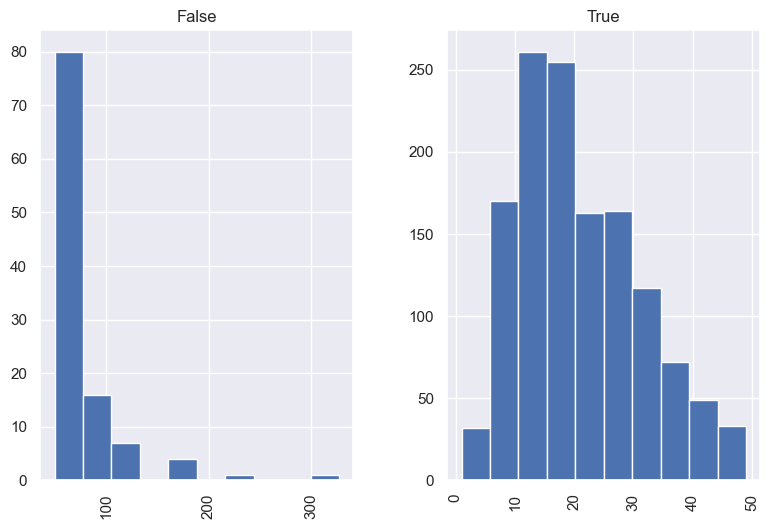

In [41]:
user_data[user_data.passed_course == True].day.hist(user_data.day < 50)                                                         #гистограмма рапсредления кол-ва прошедших курс по числу дней на курсе (ограниение шкалы day 50)

In [42]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'}, axis=1)                    #время начала курса для каждого пользователя

In [43]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [44]:
user_data = user_data.merge(user_min_time, how='outer')                                        #объединяем датафреймы 

In [45]:
user_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [46]:
learning_day = 3*24*60*60                                                                      #3 дня в секундах

In [47]:
user_data['min_time + 3days'] = user_data.min_timestamp + learning_day                         #добавляем в новую колонку время равное 3 дням обучения с начала курса

In [48]:
user_data_temp = user_data[['user_id','min_time + 3days']]                                     #временная таблица

In [49]:
"""ОТБИРАЕМ ДАННЫЕ ПО ПЕРВЫМ ТРЕМ ДНЯМ ИЗ events_data"""

'ОТБИРАЕМ ДАННЫЕ ПО ПЕРВЫМ ТРЕМ ДНЯМ ИЗ events_data'

In [50]:
events_data_temp = events_data.merge(user_data_temp, on = 'user_id', how = 'outer')            #добавляем время '3-х' дней в events_data

In [51]:
events_data_train = events_data_temp[events_data_temp['timestamp'] <= events_data_temp['min_time + 3days'] ]     #выбираем из полученной таблицы данные за первые три дня с начала курса каждым пользователем

In [52]:
events_data_train

,step_id,timestamp,action,user_id,date,day,min_time + 3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1527031950


In [53]:
events_data_train.groupby('user_id').agg({'day':'nunique'}).max()                          #проверка , что число уникальных дней не более 4

day    4
dtype: int64

In [54]:
"""ОТБИРАЕМ ДАННЫЕ ПО ПЕРВЫМ ТРЕМ ДНЯМ ИЗ submission_data"""


'ОТБИРАЕМ ДАННЫЕ ПО ПЕРВЫМ ТРЕМ ДНЯМ ИЗ submission_data'

In [55]:
submission_data_temp = submission_data.merge(user_data_temp, on = 'user_id', how = 'outer')

In [56]:
submission_data_train = submission_data_temp[submission_data_temp['timestamp'] <= submission_data_temp['min_time + 3days'] ]

In [57]:
submission_data_train.groupby('user_id').agg({'day':'nunique'}).max()

day    4
dtype: int64

In [58]:
"""Формируем переменные X"""


'Формируем переменные X'

In [59]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})   #Число уникальных дней пользователя на курсе

In [60]:
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [61]:
steps_tried = submission_data_train.groupby('user_id').step_id.nunique()\
    .to_frame().reset_index().rename(columns={'step_id':'steps_tried'})                                #кол-во уникальных шагов, которые проходил пользователь за первые 3 дня

In [62]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [63]:
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [64]:
X = X.merge(submission_data_train.pivot_table(index='user_id',                               
                                                 columns='submission_status',
                                                 values='step_id',
                                                 aggfunc='count', fill_value=0).reset_index())         #добавляем колонки с числом правильных и неправильных ответов пользователя с помошью пивот-таблицы

In [65]:
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [66]:
X['correct_ratio'] = (X.correct/(X.correct + X.wrong)).round(2)                                        #добаляем колонку с долей верных ответов

In [67]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.00
8909,26790,1,1,1,0,1.00
8910,26794,3,27,31,9,0.78
8911,26797,1,2,2,0,1.00


In [68]:
                                                                                        #добаляем колонку с числом просмотров курса пользователем за 3 дня
X = X.merge(events_data_train.pivot_table(index='user_id',                               
                                                 columns='action',
                                                 values='step_id',
                                                 aggfunc='count', fill_value=0).reset_index()[['user_id','viewed']], how ='outer')

In [69]:
 X = X.fillna(0)                                                                        #меняем NaN на 0 (т.к. соединяли по outer и в events_data_train было больше строк)

In [70]:
X = X.merge(user_data[['user_id','passed_course', 'is_gone']], on='user_id', how='outer')          #добавляем колонки из user_data


In [71]:
X = X.query('passed_course==True or is_gone==True')                                     #отбираем пользователей, которые прошли курс, либо которые бросили его

In [72]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [73]:
y = X.passed_course.map(int)                                                            #создаем переменную y c конвертацией значений в int, False принимает значение 0

In [74]:
X = X.drop(['passed_course', 'is_gone'], axis=1)                                       #удаляем из X ненужные столбцы 

In [75]:
X = X.set_index(X.user_id)                                                             #делаем из колонки user_id индексы

In [76]:
X = X.drop(['user_id'], axis=1)

In [77]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [78]:
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64

In [79]:
"""Строим модели и делаем прогнозы"""         """1. Модель дерева решений"""

'Строим модели и делаем прогнозы1. Модель дерева решений'

In [80]:
from sklearn import tree



In [81]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [82]:
from sklearn.metrics import precision_score, recall_score

In [83]:
from sklearn import metrics

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=41)           #разделяем все данные на тренировочные и тестовые

In [85]:
clf = tree.DecisionTreeClassifier()                                              #заготовка модели дерева без параметров

In [86]:
parameters = {'criterion':['gini', 'entropy'], 'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}          #словарь подбираемых параметров и их значения

In [87]:
grid_search_cv_clf = GridSearchCV(clf,parameters,cv=4)                          #заготовка поискового алгоритма

In [88]:
grid_search_cv_clf.fit(X_train, y_train)                                        #ищем лучшую модель на тренировочных данных

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 6),
                         'max_leaf_nodes': range(6, 15),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 5)})

In [89]:
model_tree = grid_search_cv_clf.best_estimator_                                 #модель дерева с лучшими параметрами

In [90]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [91]:
cross_val_score(model_tree,X_train,y_train,cv=4).mean()                         #средняя точность валидации на тренировочных данных

0.9220878509869336

In [92]:
model_tree.score(X_test, y_test)                                                #точность модели на тетсовых данных

0.9271615234917987

In [93]:
y_pred = model_tree.predict(X_test)                                             #прогноз по теcтовым данным

In [94]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [95]:
precision_score(y_test, y_pred)                             #Оценка точности модели TruePositive/(TruePositive + FalsePositive)

0.8387096774193549

In [96]:
recall_score(y_test, y_pred)                                ##Оценка точности модели TruePositive/(TruePositive + FalseNegative)

0.09187279151943463

In [97]:
predictions_tree = pd.DataFrame(data = y_pred, columns = ['prediction'])

In [98]:
X_test_tree = X_test.assign(prediction = y_pred)           ##добавили к X_test колонку с прогнозом           

In [99]:
                            """2. Логистическая Регрессия"""

'2. Логистическая Регрессия'

In [100]:
from sklearn.linear_model import LogisticRegressionCV

In [101]:
clf1 = LogisticRegressionCV(cv=5)

In [102]:
clf1.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

In [103]:
clf1.score(X_test,y_test)

0.926605504587156

In [104]:
cross_val_score(clf1,X_train,y_train,cv=4).mean()

0.9217403391715319

In [105]:
y_pred1 = clf1.predict(X_test)

In [106]:
precision_score(y_test, y_pred1)

0.6557377049180327

In [107]:
recall_score(y_test, y_pred1)

0.1413427561837456

In [108]:
            """Алгоритм ближайшего соседа"""

'Алгоритм ближайшего соседа'

In [109]:
from sklearn.neighbors import KNeighborsClassifier

In [110]:
knn = KNeighborsClassifier()

In [111]:
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}

In [112]:
grid_search_cv_knn = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)

In [113]:
grid_search_cv_knn.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': range(1, 7),
                         'n_neighbors': range(15, 25)})

In [114]:
model_knn = grid_search_cv_knn.best_estimator_

In [115]:
cross_val_score(model_knn,X_train,y_train,cv=4).mean()

0.920975813177648

In [116]:
y_pred2 = model_knn.predict(X_test)

In [117]:
precision_score(y_test, y_pred2)

0.5277777777777778

In [118]:
recall_score(y_test, y_pred2)

0.06713780918727916

In [119]:
#Функция для расчета метрик
def all_metrics(model, X_test, y_test):
    observations = y_test
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    print('True Positive: ', tp)
    print('False Positive: ', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1_score)
    
    metrics.plot_roc_curve(model, X_test, y_test)
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    metrics.plot_confusion_matrix(model, X_test, y_test)

In [120]:
"""Подбираем лучшее соотношение recall и precision для модели knn"""

'Подбираем лучшее соотношение recall и precision для модели knn'

In [121]:
from sklearn.metrics import f1_score

C:\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


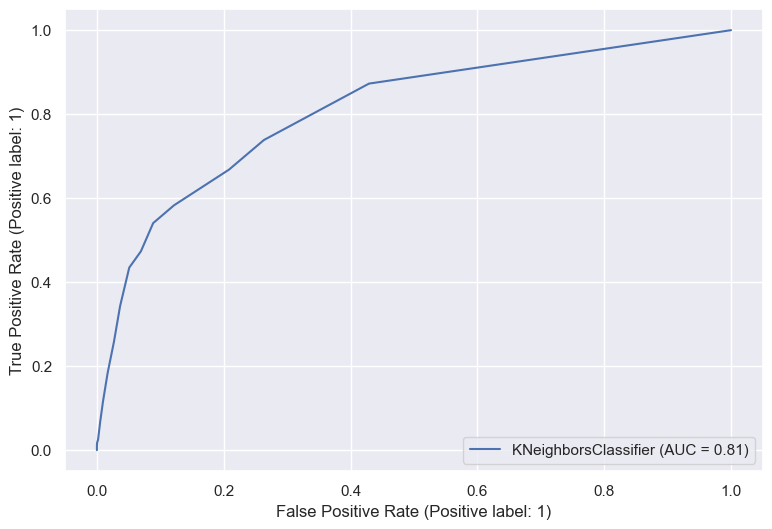

In [122]:
metrics.plot_roc_curve(model_knn, X_test, y_test)                     #строим roc Receiver operating characteristic кривую для поиска оптимального соотношения recall и presition AUC = area under the curve

C:\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


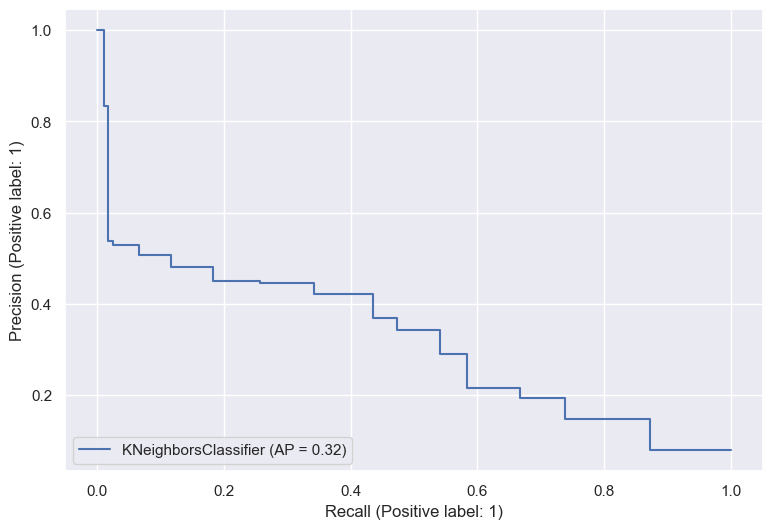

In [123]:
metrics.plot_precision_recall_curve(model_knn, X_test, y_test)        #строим кривую recall-presition

In [124]:
"""Тюним прогноз, чтобы добиться лучшего соотношения recall и presition"""

'Тюним прогноз, чтобы добиться лучшего соотношения recall и presition'

In [125]:
y_prob_knn = model_knn.predict_proba(X_test)                          #массив с вероятностями отнесения наблюдения к 0 (False passed course) или 1 классу

In [126]:
y_new_knn = np.where(y_prob_knn[:,0]>0.87, 0, 1)                      #делаем новый прогноз 'y'. Ставим класс 0, если вероятность в первой колонке (отнесение к классу False) y_prob больше заданного значения

In [127]:
recall_score(y_test, y_new_knn)

0.6678445229681979

In [128]:
precision_score(y_test, y_new_knn)

0.2150170648464164

In [129]:
f1_score(y_test, y_new_knn)

0.3253012048192771

In [130]:
model_tree.feature_importances_

array([0.01843832, 0.07868428, 0.86833154, 0.00803861, 0.0086917 ,
       0.01781556])

In [131]:
model_tree_feature_importances = pd.DataFrame({'feature': X.columns, 'impotance': model_tree.feature_importances_ })

In [132]:
model_tree_feature_importances

,feature,impotance
0,days,0.018438
1,steps_tried,0.078684
2,correct,0.868332
3,wrong,0.008039
4,correct_ratio,0.008692
5,viewed,0.017816


<AxesSubplot:ylabel='feature'>

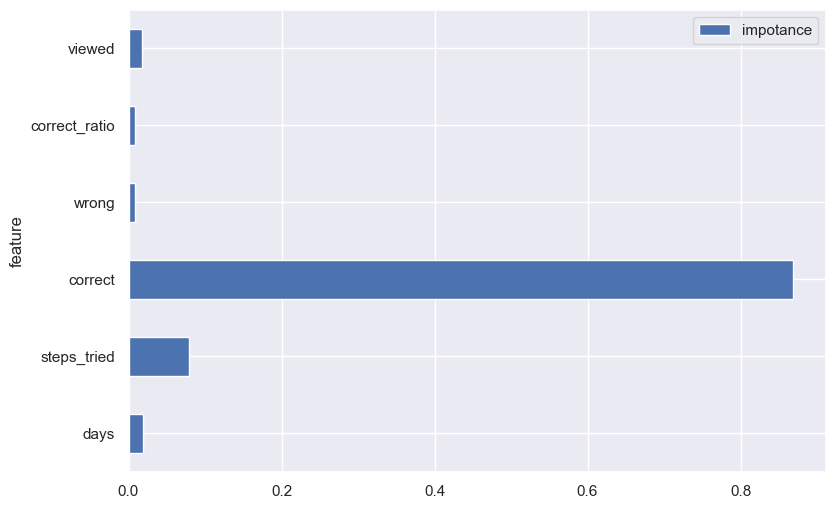

In [133]:
model_tree_feature_importances.plot(kind='barh', x ='feature')